In [1]:
import math, random

import gymnasium as gym
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
USE_CUDA = torch.cuda.is_available()
device = lambda inp: inp.cuda() if USE_CUDA else inp

In [3]:
## ENVIRONMENT

env_id = "CartPole-v1"

Prioritized experience replay

Paper: https://arxiv.org/pdf/1511.05952

In [4]:
## REPLAY BUFFER

class NStepPrioritizedReplayBuffer:
    def __init__(self, capacity, num_training, n_step, num_env, gamma, prob_alpha=0.6, beta_0=0.4):
        self.prob_alpha = prob_alpha
        self.beta_0 = beta_0
        self.capacity = (capacity // num_env) * num_env
        self.num_training = num_training
        self.n_step = n_step
        self.num_env = num_env
        self.gamma = gamma
        self.buffer = []
        self.pos = 0
        self.prio_alp = np.zeros((self.capacity,), dtype=np.float32)
        self.max_prio_alp = 1.
    
    def push(self, batch_state, batch_action, batch_reward, batch_next_state, batch_done, batch_truncated):
        num_samples = batch_state.shape[0]
        assert num_samples == self.num_env, 'The same index of different batches must be from the same environment'
        buffer_len = len(self.buffer)
        pos = (self.pos + np.arange(num_samples)) % self.capacity
        
        if buffer_len < self.capacity:
            for i in range(num_samples):
                self.buffer.append(
                    (batch_state[i].reshape(1,-1),
                     batch_action[i],
                     batch_reward[i],
                     batch_next_state[i].reshape(1,-1),
                     batch_done[i],
                     batch_truncated[i])
                )
        else:
            if self.prio_alp[pos].max() == self.max_prio_alp:
                mask = np.ones_like(self.prio_alp)
                mask[pos] = 0
                self.max_prio_alp = (self.prio_alp * mask).max()
            for i in range(num_samples):
                self.buffer[pos[i]] = (
                    batch_state[i].reshape(1,-1),
                    batch_action[i],
                    batch_reward[i],
                    batch_next_state[i].reshape(1,-1),
                    batch_done[i],
                    batch_truncated[i]
                )

        self.prio_alp[pos] = self.max_prio_alp
        self.pos = (self.pos + num_samples) % self.capacity
    
    def sample(self, batch_size, training_idx, model_greedy_func=None):
        beta = min(1.0, self.beta_0 + training_idx * (1.0 - self.beta_0) / self.num_training)
        buffer_len = len(self.buffer)
        
        if buffer_len == self.capacity:
            prio_alps = self.prio_alp
        else:
            prio_alps = self.prio_alp[:self.pos]

        # P_j = p_j^{\alpha} / {\sum_i p_i^{\alpha}}
        probs = prio_alps / prio_alps.sum()

        last_indices = np.random.choice(buffer_len, batch_size, p=probs)

        # model action
        if not(model_greedy_func is None):
            model_states = list()
            for lidx in last_indices.tolist():
                for n in range(0, self.n_step):
                    # all wrong indices will be filtered out later
                    idx = (lidx - n * self.num_env) % buffer_len
                    model_states.append(self.buffer[idx][0])
            model_act = model_greedy_func(np.concatenate(model_states)).reshape(-1, self.n_step)
        else:
            model_act = np.zeros((batch_size, self.n_step))
            for i, lidx in enumerate(last_indices.tolist()):
                for n in range(0, self.n_step):
                    # all wrong indices will be filtered out later
                    idx = (lidx - n * self.num_env) % buffer_len
                    model_act[i,n] = self.buffer[idx][1]

        # get samples
        indices = list()
        steps = list()
        rewards = list()
        states = list()
        actions = list()
        next_states = list()
        dones = list()
        for i, lidx in enumerate(last_indices.tolist()):
            last_ep_idx = lidx
            step = 0
            reward = 0
            next_step_diverge = False
            cross_boundary = False
            for n in range(0, self.n_step):
                if buffer_len == self.capacity:
                    idx = (lidx - n * self.num_env) % self.capacity
                    idx_diff = (self.pos - idx) % self.capacity
                    if (idx_diff <= self.num_env) and (idx_diff > 0) and (n > 0):
                        cross_boundary = True
                    else:
                        cross_boundary = False
                else:
                    idx = lidx - n * self.num_env
                    if idx < 0:
                        break
                cur_idx_done = self.buffer[idx][4]
                cur_idx_truncated = self.buffer[idx][5]
                if (cross_boundary or cur_idx_done or next_step_diverge or cur_idx_truncated) and (n > 0):
                    last_ep_idx = idx
                    step = 0
                    reward = 0
                step += 1
                reward = self.buffer[idx][2] + self.gamma * reward
                indices.append(idx)
                steps.append(step)
                rewards.append(reward)
                states.append(self.buffer[idx][0])
                actions.append(self.buffer[idx][1])
                next_states.append(self.buffer[last_ep_idx][3])
                dones.append(self.buffer[last_ep_idx][4])
                target_act = self.buffer[idx][1]
                if target_act != model_act[i,n]:
                    next_step_diverge = True
                else:
                    next_step_diverge = False
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)

        # w_j = (N  * P_j)^{-\beta}
        # w_j = w_j / {\max_i w_i}
        weights  = (buffer_len * probs[indices]) ** (-beta)
        weights /= (buffer_len * probs.min()) ** (-beta)
        weights  = np.array(weights, dtype=np.float32)
        
        return states, actions, rewards, next_states, dones, steps, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        prev_max_prio_alps = self.prio_alp[batch_indices].max()
        # p_i^{\alpha}
        prio_alps = batch_priorities ** self.prob_alpha
        self.prio_alp[batch_indices] = prio_alps
        max_prio_alps = prio_alps.max()
        if max_prio_alps > self.max_prio_alp:
            self.max_prio_alp = max_prio_alps
        elif prev_max_prio_alps == self.max_prio_alp:
            self.max_prio_alp = self.prio_alp.max()

    def __len__(self):
        return len(self.buffer)

In [5]:
## NEURAL NETWORK

class Net(nn.Module):
    def __init__(self, num_inputs, num_actions, v_min, v_max, num_atoms=51):
        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, num_actions * num_atoms)
        )
        self.softmax = nn.Softmax(dim=-1)
        
        self.num_actions = num_actions
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        z = torch.linspace(v_min, v_max, num_atoms)
        self.register_buffer('z', z)
        
    def forward(self, x):
        return self.softmax(self.layers(x).view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
    
    def eps_act(self, state, epsilon):
        select = np.random.rand(state.shape[0]) > epsilon
        action = select * self.greedy_act(state) + np.logical_not(select) * np.random.randint(0, self.num_actions, size=state.shape[0])
        return action
    
    def greedy_act(self, state):
        state = device(torch.FloatTensor(state))
        with torch.no_grad():
            dist = self.forward(state)
        q_values = (self.z.view(1,1,-1) * dist).sum(dim=-1)
        action = q_values.max(dim=-1)[1].cpu().numpy()
        return action

Categorical DDQN

Paper:
- https://arxiv.org/pdf/1509.06461
- https://proceedings.mlr.press/v70/bellemare17a/bellemare17a.pdf

target: $R_{t+1}+{\gamma}Q\left(S_{t+1}, \arg\max_{a'}{Q\left(S_{t+1}, a';\theta_t\right)};\theta^-_t\right)$

In [6]:
## DDQN Agent

class CategoricalDDQNAgent:
    def __init__(self, env_id, eps, gamma, lr, num_frames, rep_buf_size, batch_size, tgt_upd_delay, n_step, v_min, v_max):
        self.envs = gym.vector.make(env_id, num_envs=batch_size)
        self.eps = eps
        self.gamma = gamma
        self.lr = lr
        self.num_frames = num_frames
        self.rep_buf_size = rep_buf_size
        self.batch_size = batch_size
        self.tgt_upd_delay = tgt_upd_delay
        self.n_step = n_step
        
        self.model = device(Net(self.envs.single_observation_space.shape[0], self.envs.single_action_space.n, v_min, v_max))
        self.target = device(Net(self.envs.single_observation_space.shape[0], self.envs.single_action_space.n, v_min, v_max))
        self.target.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.rep_buf = NStepPrioritizedReplayBuffer(rep_buf_size, num_frames, n_step, batch_size, gamma)

    def train(self):
        losses = []
        all_rewards = []
        episode_reward = np.zeros(self.batch_size)
        
        state, _ = self.envs.reset()
        for frame_idx in range(0, self.num_frames):
            action = self.model.eps_act(state, self.eps)
            
            next_state, reward, terminated, truncated, info = self.envs.step(action)
            done = terminated
            rep_buf_next_state = np.stack(
                [
                    info['final_observation'][i] if truncated[i] else next_state[i,:]
                    for i in range(truncated.shape[0])
                ],
                axis=0
            )
            self.rep_buf.push(state, action, reward, rep_buf_next_state, done, truncated)

            if (frame_idx % self.tgt_upd_delay) == 0:
                self.target.load_state_dict(self.model.state_dict())
            loss = self.compute_td_loss(frame_idx)
            losses.append(loss.item())
            
            state = next_state
            
            episode_reward += reward
            all_rewards.extend(episode_reward[np.logical_or(done, truncated)].tolist())
            episode_reward[np.logical_or(done, truncated)] = 0
                
            if (frame_idx + 1) % 200 == 0:
                self.plot_training(frame_idx, all_rewards, losses)
        
        self.envs.close()

    def compute_td_loss(self, frame_idx):
        state, action, reward, next_state, done, step, indices, weights = \
            self.rep_buf.sample(self.batch_size, frame_idx, self.model.greedy_act)
        
        state      = device(torch.FloatTensor(state))
        next_state = device(torch.FloatTensor(next_state))
        action     = device(torch.LongTensor(action))
        reward     = device(torch.FloatTensor(reward))
        done       = device(torch.FloatTensor(done))
        step       = device(torch.FloatTensor(step))
        weights    = device(torch.FloatTensor(weights))

        model_dist = self.model(state)
        model_action = action.view(-1,1,1).expand(-1, -1, self.model.num_atoms) 
        model_dist = model_dist.gather(1, model_action).squeeze(1)  # [B,n_A]
        model_dist.data.clamp_(0.000001, 0.999999)

        proj_dist = self.projection_distribution(next_state, reward, done, step)

        loss = - (proj_dist * model_dist.log()).sum(dim=-1)
        self.rep_buf.update_priorities(indices, np.abs(loss.detach().cpu().numpy()) + 1e-5)
        loss = loss * weights
        loss = loss.mean()
            
        self.optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.)
        self.optimizer.step()
        
        return loss

    def projection_distribution(self, next_states, rewards, dones, steps):
        batch_size  = next_states.size(0)
        num_atoms = self.model.num_atoms
        v_max = self.model.v_max
        v_min = self.model.v_min
        delta_z = float(v_max - v_min) / (num_atoms - 1)
        z = self.model.z
    
        # get a_{t+1}
        with torch.no_grad():
            model_next_dist = z * self.model(next_states)  # [B,A,n_A]
        model_next_action = model_next_dist.sum(dim=-1).max(1)[1] # [B]
        model_next_action = model_next_action.view(-1,1,1).expand(-1, -1, num_atoms)  # [B,1,n_A]
    
        # get p(x_{t+1},a_{t+1})
        with torch.no_grad():
            target_next_dist = self.target(next_states) # [B,A,n_A]
        target_next_dist = target_next_dist.gather(1, model_next_action).squeeze(1) # [B,n_A]
        
        Tz = rewards.view(-1,1) + torch.pow(self.gamma, steps).view(-1,1) * (1 - dones).view(-1,1) * z.view(1,-1) # [B,n_A]
        Tz = Tz.clamp(min=v_min, max=v_max) # [B,n_A]
        b  = (Tz - v_min) / delta_z # [B,n_A]
        l  = b.floor().long() # [B,n_A]
        u  = b.ceil().long() # [B,n_A]
            
        offset = device(torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long().view(-1,1).expand(-1, num_atoms)) # [B,n_A]
    
        proj_dist = torch.zeros_like(target_next_dist) # [B,n_A]   
        proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (target_next_dist * (u.float() - b)).view(-1))
        proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (target_next_dist * (b - l.float())).view(-1))
            
        return proj_dist

    @staticmethod
    def plot_training(frame_idx, rewards, losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('episode: {}, total reward(ma-10): {}'.format(len(rewards), np.mean(rewards[-10:])))
        plt.plot(np.array(rewards)[:100 * (len(rewards) // 100)].reshape(-1, 100).mean(axis=1))
        plt.subplot(132)
        plt.title('frame: {}, loss(ma-10): {:.4f}'.format(frame_idx, np.mean(losses[-10:])))
        plt.plot(losses)
        plt.show()

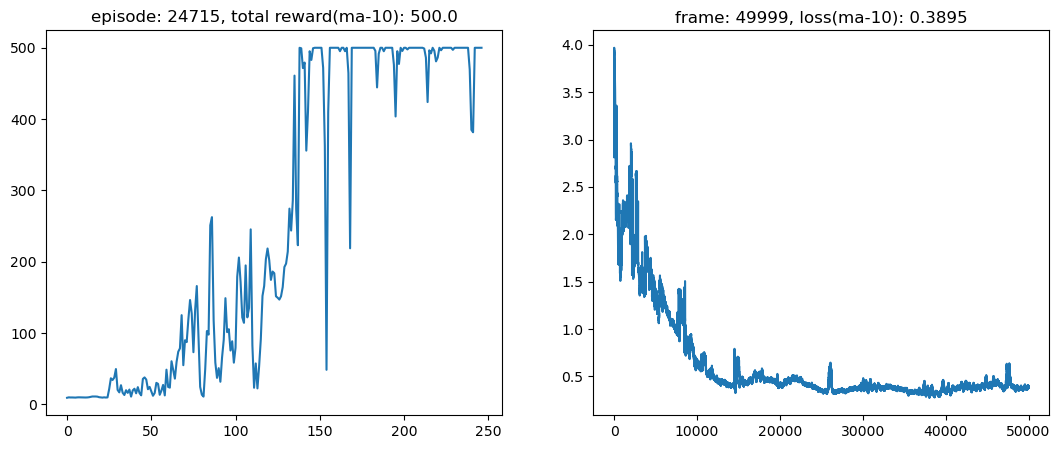

In [7]:
## Training

cat_ddqn_agent = CategoricalDDQNAgent(
    env_id=env_id,
    eps=0.05,
    gamma=0.99,
    lr=5e-4,
    num_frames=50000,
    rep_buf_size=10000,
    batch_size=128,
    tgt_upd_delay=50,
    n_step=10,
    v_min=0,
    v_max=500)
cat_ddqn_agent.train()

In [10]:
## Visualization (Test)

env = gym.make(env_id, render_mode='human')
state, _ = env.reset()
done = False
while not done:
    action = cat_ddqn_agent.model.greedy_act(np.expand_dims(state, 0))
    state, reward, terminated, truncated, _ = env.step(action[0])
    done = terminated or truncated
    env.render()
env.close()